In [32]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import joblib

In [22]:
data = pd.read_csv('../data/MercadoLibre Data Scientist Technical Challenge - Dataset.csv')
selected_features = pd.read_csv('../data/processed/selected_features.csv')['0'].to_list()
fraud_pipeline = joblib.load('../models/feature_engineering_pipeline.joblib')
print(selected_features)
print(data.shape)
data.head()

['b', 'c', 'h', 'j', 'k', 'l', 'm', 'o', 'monto', 'score', 'fecha_hour', 'fecha_minute', 'fecha_second']
(150000, 19)


,a,b,c,d,e,f,g,h,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.6812,50084.12,50.0,0.000000,20.0,AR,1,cat_d26ab52,0.365475,2479.0,952.0,1,NaN,Y,2020-03-20 09:28:19,57.63,100,0
1,4,0.6694,66005.49,0.0,0.000000,2.0,AR,1,cat_ea962fb,0.612728,2603.0,105.0,1,Y,Y,2020-03-09 13:58:28,40.19,25,0
2,4,0.4718,7059.05,4.0,0.463488,92.0,BR,25,cat_4c2544e,0.651835,2153.0,249.0,1,Y,Y,2020-04-08 12:25:55,5.77,23,0
3,4,0.7260,10043.10,24.0,0.046845,43.0,BR,43,cat_1b59ee3,0.692728,4845.0,141.0,1,N,Y,2020-03-14 11:46:13,40.89,23,0
4,4,0.7758,16584.42,2.0,0.154616,54.0,BR,0,cat_9bacaa5,0.201354,2856.0,18.0,1,Y,N,2020-03-23 14:17:13,18.98,71,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['fraude'], axis=1), # predictive variables
    data['fraude'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((135000, 18), (15000, 18))

In [24]:
X_train_transformed = fraud_pipeline.transform(X_train)
X_test_transformed = fraud_pipeline.transform(X_test)

In [25]:
from sklearn import model_selection
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
            ('LogReg', LogisticRegression()), 
            ('RF', RandomForestClassifier()),
            ('KNN', KNeighborsClassifier()),
           # ('SVM', SVC()), 
            ('GNB', GaussianNB()),
            ('XGB', XGBClassifier(objective= "binary:logistic",eval_metric = "mlogloss",use_label_encoder=False))
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['No Fraude', 'Fraude']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)[:, 1]

        # Calcula el ROC-AUC con diferentes umbrales
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)

        # Encuentra el umbral óptimo que maximiza el AUC
        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]

        y_pred = (y_prob >= optimal_threshold).astype(int)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        this_df['optimize_threshold'] = optimal_threshold
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [26]:
data = run_exps(X_train_transformed, y_train.values.ravel(), X_test_transformed, y_test.values.ravel())

LogReg
              precision    recall  f1-score   support

   No Fraude       0.98      0.79      0.88     14236
      Fraude       0.16      0.76      0.27       764

    accuracy                           0.79     15000
   macro avg       0.57      0.78      0.57     15000
weighted avg       0.94      0.79      0.85     15000

RF
              precision    recall  f1-score   support

   No Fraude       0.99      0.81      0.89     14236
      Fraude       0.18      0.79      0.29       764

    accuracy                           0.81     15000
   macro avg       0.58      0.80      0.59     15000
weighted avg       0.95      0.81      0.86     15000

KNN
              precision    recall  f1-score   support

   No Fraude       0.97      0.85      0.91     14236
      Fraude       0.16      0.51      0.24       764

    accuracy                           0.84     15000
   macro avg       0.56      0.68      0.58     15000
weighted avg       0.93      0.84      0.87     15000

GNB
 

In [27]:
bootstraps = []

for model in list(set(data.model.values)):
    model_df = data.loc[data.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [28]:
bootstrap_df[bootstrap_df['test_roc_auc'] == bootstrap_df['test_roc_auc'].max()]

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model,optimize_threshold
8,100.602813,0.136535,0.954852,0.945523,0.954852,0.946068,0.878953,XGB,0.050189
9,100.602813,0.136535,0.954852,0.945523,0.954852,0.946068,0.878953,XGB,0.050189
10,100.602813,0.136535,0.954852,0.945523,0.954852,0.946068,0.878953,XGB,0.050189
12,100.602813,0.136535,0.954852,0.945523,0.954852,0.946068,0.878953,XGB,0.050189
14,100.602813,0.136535,0.954852,0.945523,0.954852,0.946068,0.878953,XGB,0.050189
18,100.602813,0.136535,0.954852,0.945523,0.954852,0.946068,0.878953,XGB,0.050189
21,100.602813,0.136535,0.954852,0.945523,0.954852,0.946068,0.878953,XGB,0.050189
24,100.602813,0.136535,0.954852,0.945523,0.954852,0.946068,0.878953,XGB,0.050189


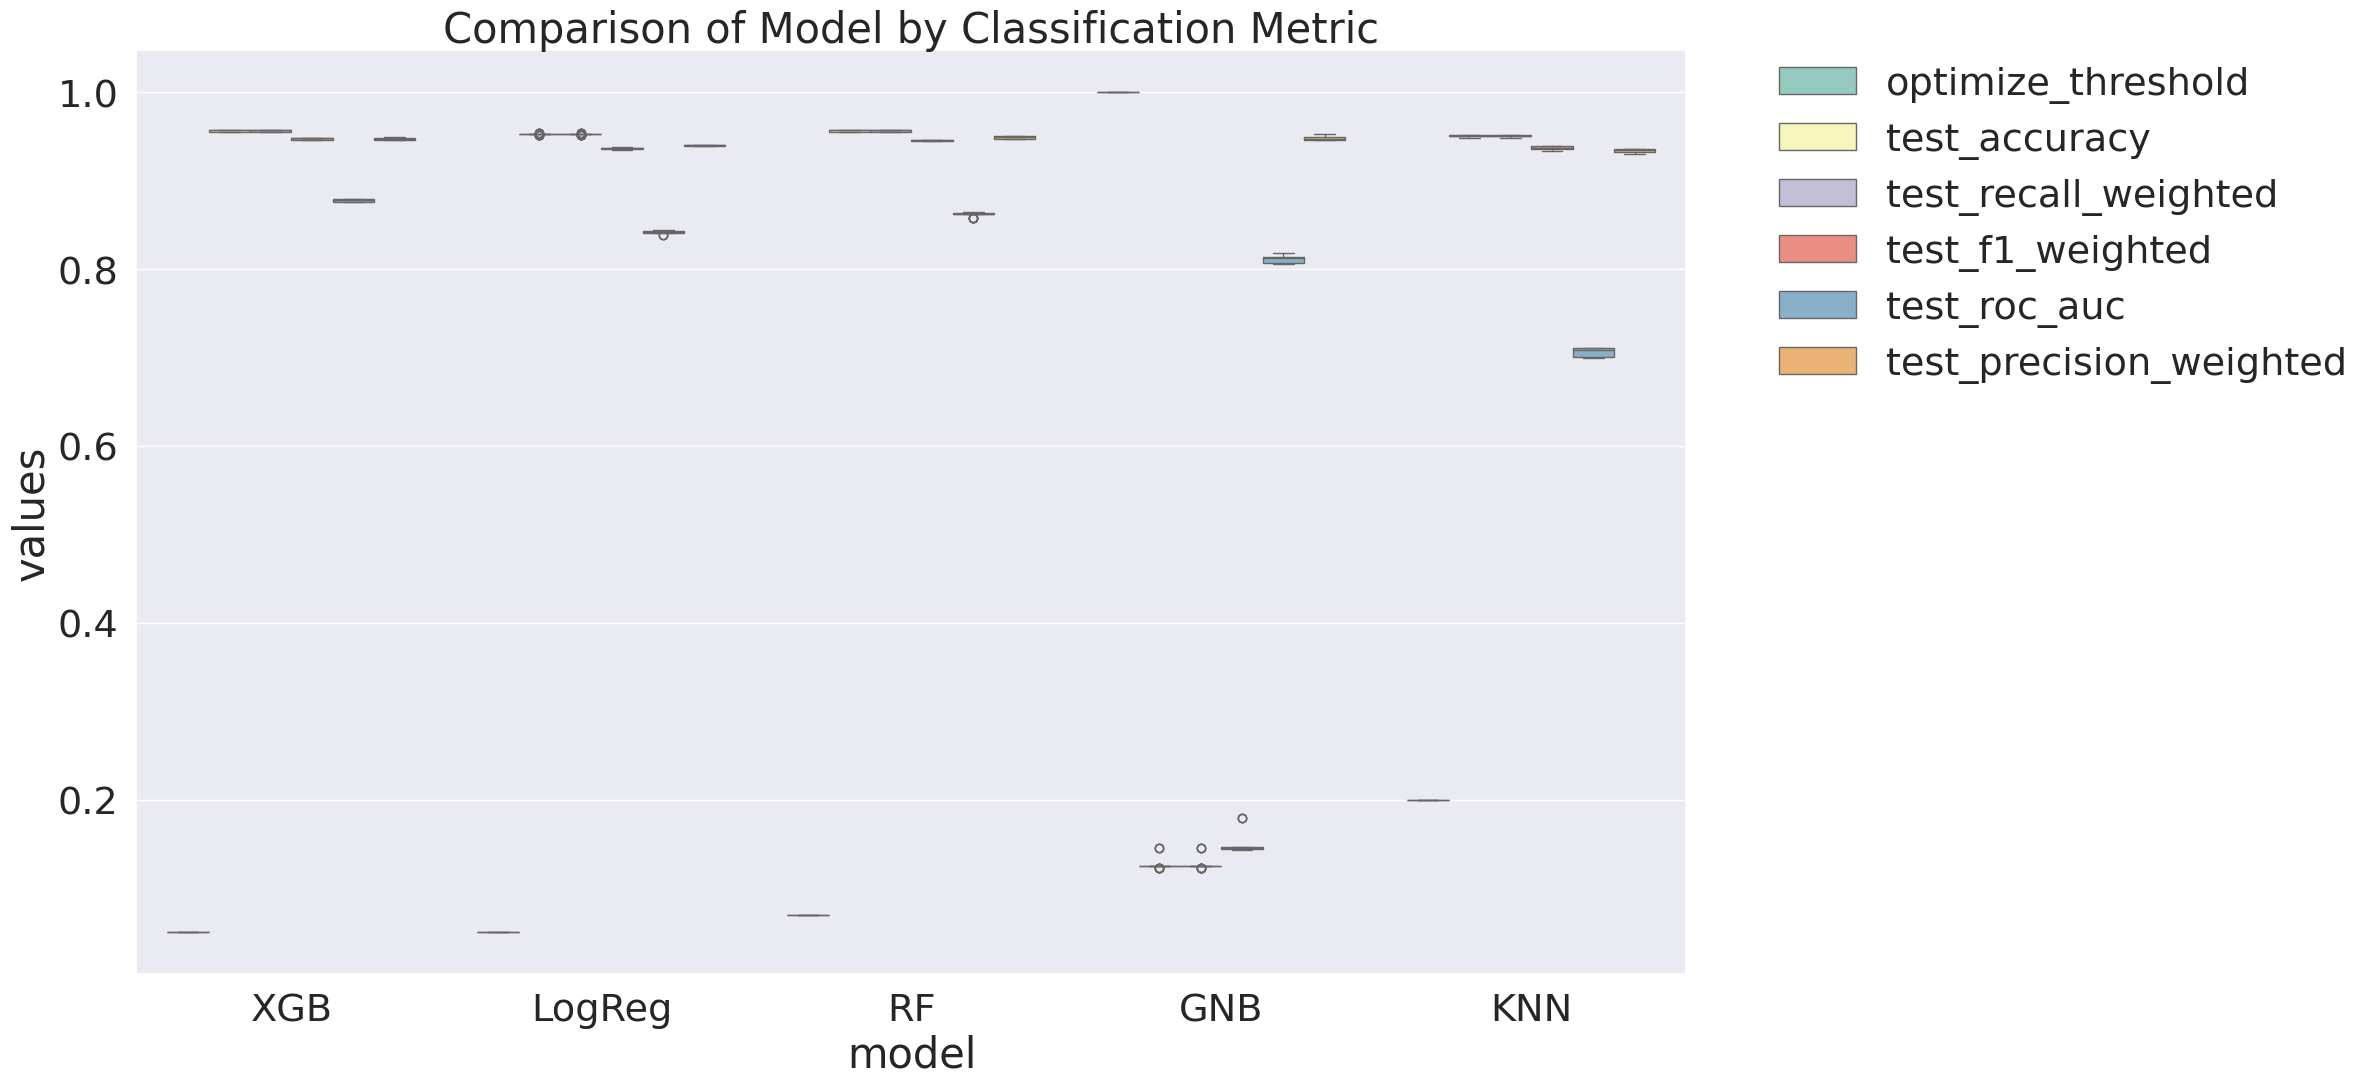

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')

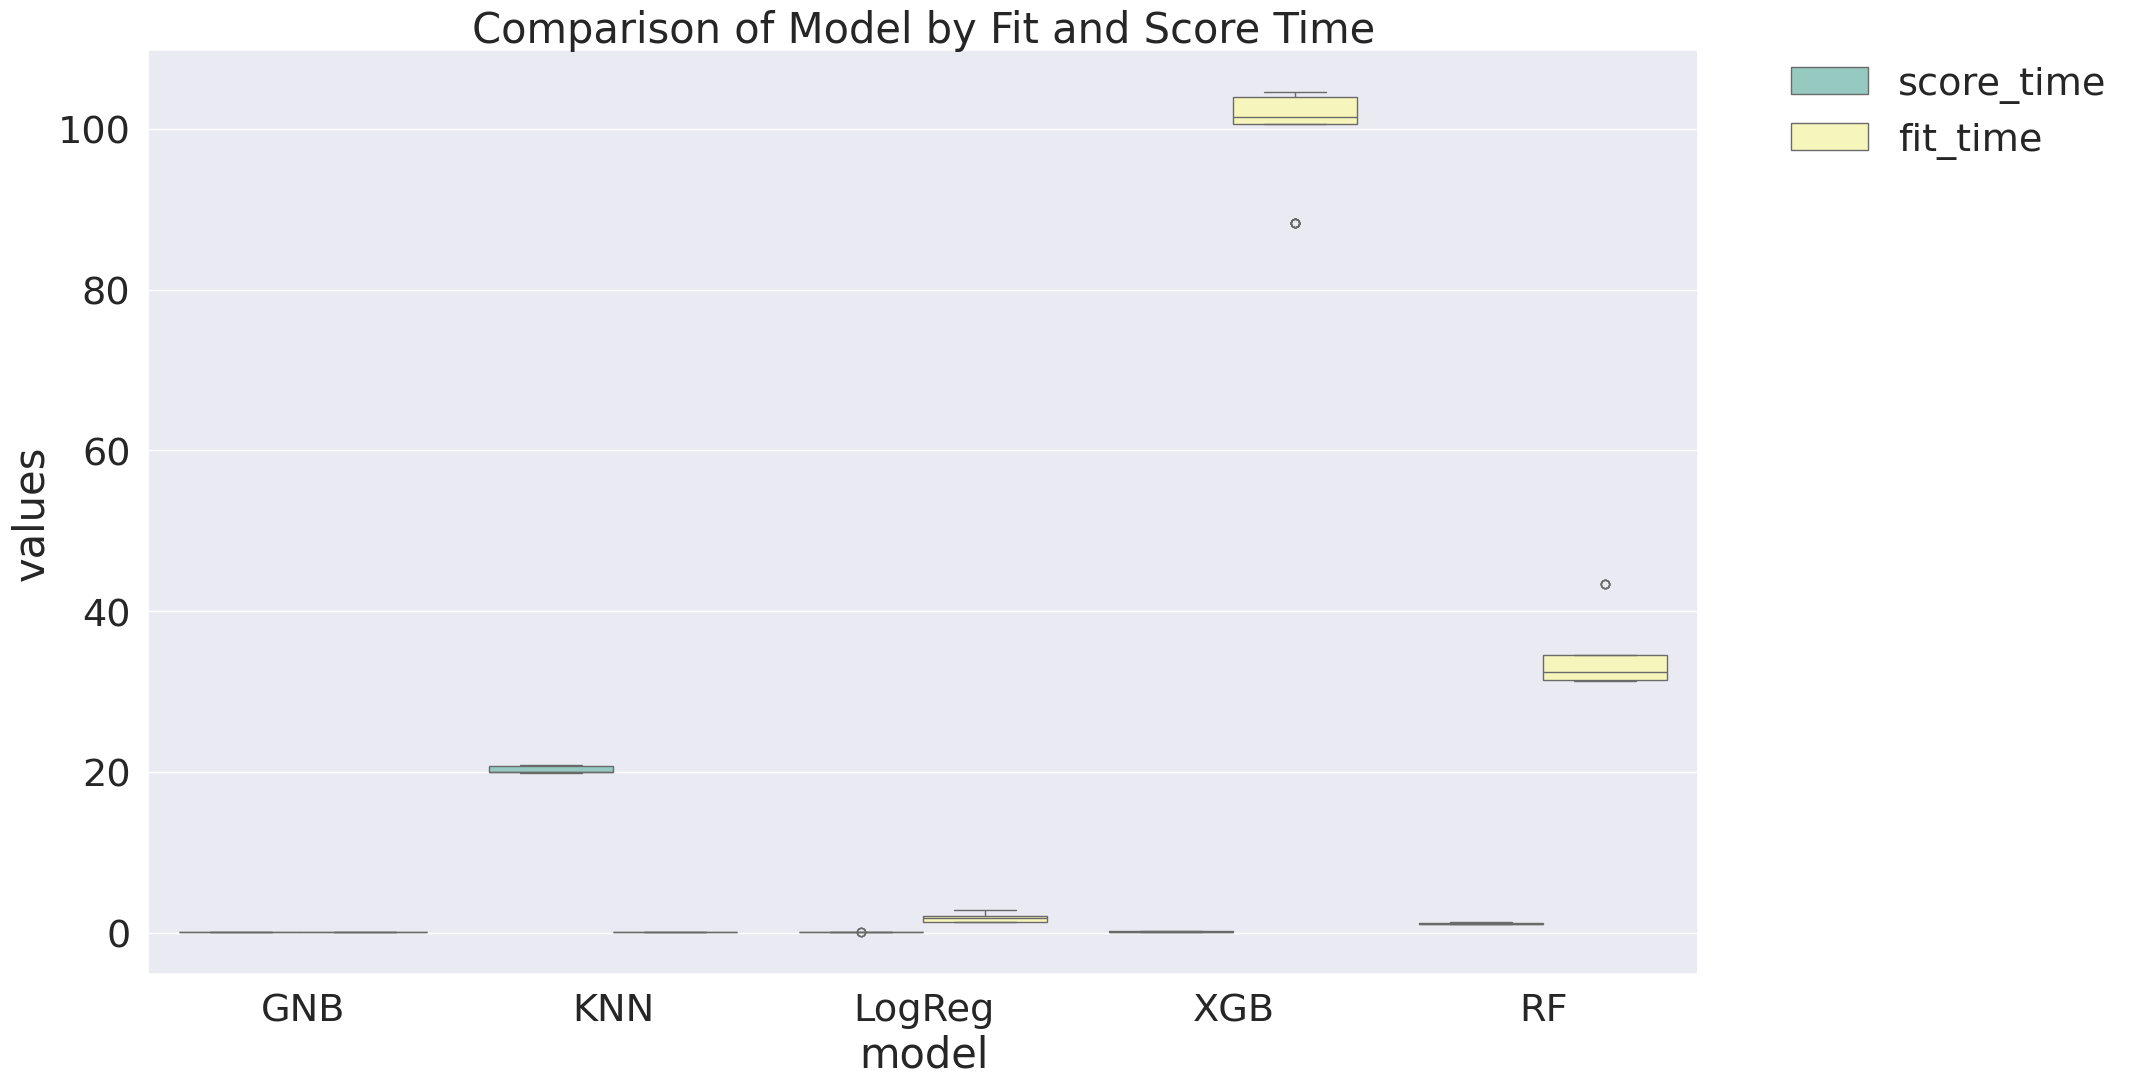

In [30]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')

Me quedo con el XGB

In [35]:
clf = XGBClassifier()
clf.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
preds_test = clf.predict_proba(X_test_transformed)[:, 1]

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_pred = (preds_test >= optimal_threshold).astype(int)

In [56]:
optimal_threshold

0.05018921

In [58]:
confusion_matrix(y_test, y_pred)

array([[12023,  2213],
       [  169,   595]])

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     14236
           1       0.21      0.78      0.33       764

    accuracy                           0.84     15000
   macro avg       0.60      0.81      0.62     15000
weighted avg       0.95      0.84      0.88     15000



In [60]:
roc_auc_score(y_test, preds_test)

0.8872237296787584

In [63]:
fraud_pipeline.steps.append(('model', clf))

In [65]:
joblib.dump(fraud_pipeline, '../models/final_pipeline.joblib')

['../models/final_pipeline.joblib']